# Imports

In [34]:
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix, precision_score, recall_score, classification_report, zero_one_loss, log_loss, ConfusionMatrixDisplay


# Turn data into DataFrame

In [35]:
parasitized_path = './cell_images/Parasitized'
uninfected_path = './cell_images/Uninfected'

data = []
for file in os.listdir(parasitized_path):
    if not ( file.endswith(".png")):
        continue
    data.append([os.path.join(parasitized_path, file), 'parasitized'])

for file in os.listdir(uninfected_path):
    if not ( file.endswith(".png")):
        continue
    data.append([os.path.join(uninfected_path, file), 'uninfected'])

df = pd.DataFrame(data, columns=['file_path', 'label'])

print(df.head())


                                           file_path        label
0  ./cell_images/Parasitized\C100P61ThinF_IMG_201...  parasitized
1  ./cell_images/Parasitized\C100P61ThinF_IMG_201...  parasitized
2  ./cell_images/Parasitized\C100P61ThinF_IMG_201...  parasitized
3  ./cell_images/Parasitized\C100P61ThinF_IMG_201...  parasitized
4  ./cell_images/Parasitized\C100P61ThinF_IMG_201...  parasitized


# Rezize and flatten the images 

In [36]:
def load_data(df):
    images = []
    labels = []
    for _, file_path, label in df.itertuples():
        img = cv2.imread(file_path)
        if img is not None:
            img = cv2.resize(img, (64, 64))
            images.append(img.flatten())
            labels.append(True if label == 'parasitized' else False)

    return np.array(images), np.array(labels)


# Get data and prepare it for training 

In [37]:
X, y = load_data(df)

In [38]:
scaler = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=54)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [39]:
log_pca = PCA(n_components=200, random_state=0)
log_X_train = log_pca.fit_transform(X_train)
log_X_test = log_pca.transform(X_test)

In [40]:
knn_pca = PCA(n_components=15, random_state=0)
knn_X_train = knn_pca.fit_transform(X_train)
knn_X_test = knn_pca.transform(X_test)

# Logistic Regression

In [41]:

log_model = LogisticRegression()
log_model.fit(log_X_train, y_train)

y_log_pred = log_model.predict(log_X_test)
print("Accuracy:", accuracy_score(y_test, y_log_pred))

Accuracy: 0.6904934687953556


# KNN Classification

In [42]:
knn_model = KNeighborsClassifier(n_neighbors=17)
knn_model.fit(knn_X_train, y_train)

y_knn_pred = knn_model.predict(knn_X_test)
print("Accuracy:", accuracy_score(y_test, y_knn_pred))

Accuracy: 0.6972060957910015


# Accuracy

In [43]:
print("Accuracy For Logistic Regression",accuracy_score(y_test,y_log_pred))
print("Accuracy For KNN",accuracy_score(y_test,y_knn_pred))

Accuracy For Logistic Regression 0.6904934687953556
Accuracy For KNN 0.6972060957910015


# Precision

In [44]:
print("Precision For Logistic Regression",precision_score(y_test,y_log_pred))
print("Precision For KNN ",precision_score(y_test,y_knn_pred))

Precision For Logistic Regression 0.6913902348117779
Precision For KNN  0.7021276595744681


# Recall

In [45]:
print("Recall For Logistic Regression",recall_score(y_test,y_log_pred))
print("Recall For KNN",recall_score(y_test,y_knn_pred))

Recall For Logistic Regression 0.6787413099158434
Recall For KNN 0.6761800219538968


# Confusion Matrix

In [46]:
print("Confusion Matrix For Logistic Regression\n",confusion_matrix(y_test,y_log_pred))
print("Confusion Matrix For KNN \n",confusion_matrix(y_test,y_knn_pred))

Confusion Matrix For Logistic Regression
 [[1951  828]
 [ 878 1855]]
Confusion Matrix For KNN 
 [[1995  784]
 [ 885 1848]]


# Confusion Matrix Display

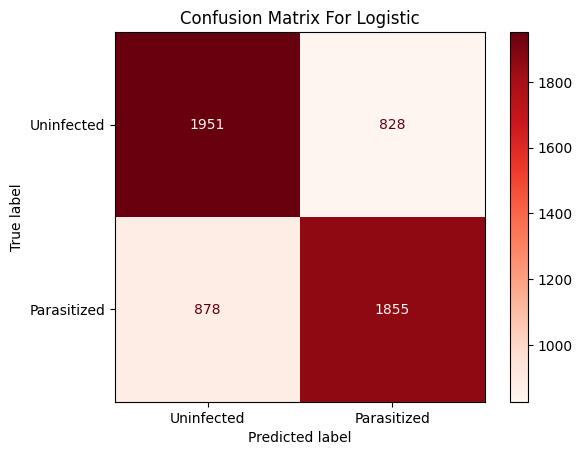

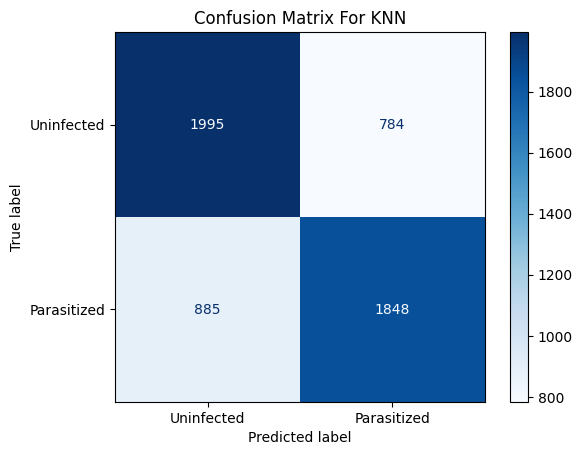

In [47]:
#Logistic
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test,y_log_pred), display_labels=['Uninfected', 'Parasitized'])
disp.plot(cmap=plt.cm.Reds)
plt.title("Confusion Matrix For Logistic")
plt.show()

#KNN
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test,y_knn_pred), display_labels=['Uninfected', 'Parasitized'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix For KNN")
plt.show()

# Plot Loss Curve

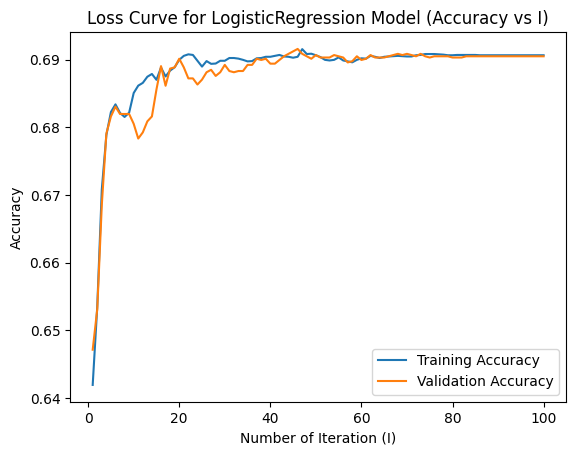

In [48]:
import warnings 

warnings.filterwarnings("ignore" , category=UserWarning)
max_iter = range(1, 101)

log_train_accuracies = []
log_pred_accuracies = []

for i in max_iter:
    log_model_loss = LogisticRegression(max_iter=i)
    log_model_loss.fit(log_X_train, y_train)
    
    train = log_model_loss.predict(log_X_train)
    pred = log_model_loss.predict(log_X_test)
    
    log_train_accuracies.append(accuracy_score(y_train, train))
    log_pred_accuracies.append(accuracy_score(y_test, pred))

plt.plot(max_iter, log_train_accuracies, label='Training Accuracy')
plt.plot(max_iter, log_pred_accuracies, label='Validation Accuracy')
plt.xlabel('Number of Iteration (I)')
plt.ylabel('Accuracy')
plt.title('Loss Curve for LogisticRegression Model (Accuracy vs I)')
plt.legend()
plt.show()

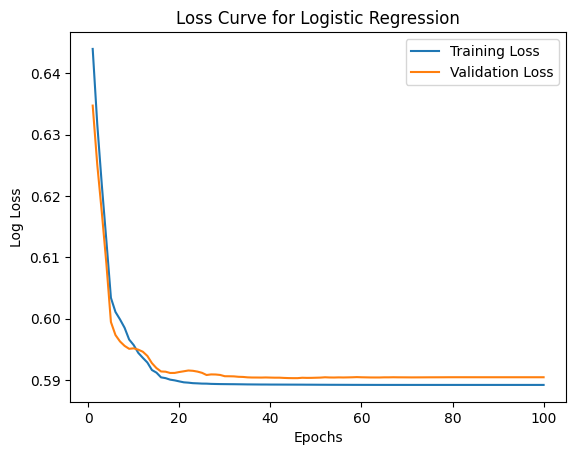

In [49]:
import warnings 

warnings.filterwarnings("ignore" , category=UserWarning)
train_losses = []
val_losses = []
for epoch in range(1, 101):
    log_model_loss = LogisticRegression(max_iter=epoch)
    log_model_loss.fit(log_X_train, y_train)
    
    train_prob = log_model_loss.predict_proba(log_X_train)
    val_prob = log_model_loss.predict_proba(log_X_test)
    
    train_losses.append(log_loss(y_train, train_prob))
    val_losses.append(log_loss(y_test, val_prob))

plt.plot(range(1, 101), train_losses, label='Training Loss')
plt.plot(range(1, 101), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Log Loss')
plt.title('Loss Curve for Logistic Regression')
plt.legend()
plt.show()

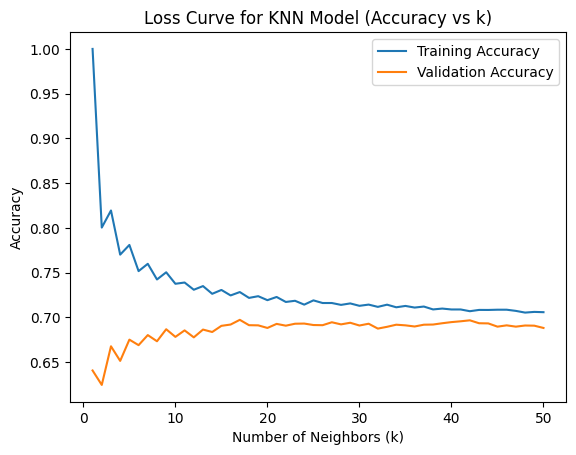

In [50]:
k_values = range(1, 51)

knn_train_accuracies = []
knn_pred_accuracies = []

for k in k_values:
    log_model_loss = KNeighborsClassifier(n_neighbors=k)
    log_model_loss.fit(knn_X_train, y_train)
    
    train = log_model_loss.predict(knn_X_train)
    pred = log_model_loss.predict(knn_X_test)

    knn_train_accuracies.append(accuracy_score(y_train, train))
    knn_pred_accuracies.append(accuracy_score(y_test, pred))

plt.plot(k_values, knn_train_accuracies, label='Training Accuracy')
plt.plot(k_values, knn_pred_accuracies, label='Validation Accuracy')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.title('Loss Curve for KNN Model (Accuracy vs k)')
plt.legend()
plt.show()

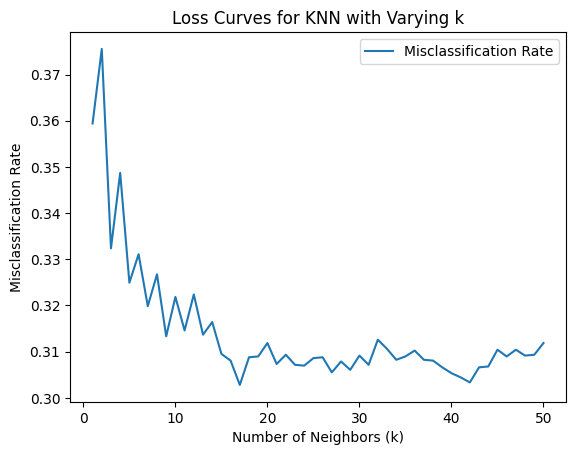

In [51]:
misclassification_rates = []

k_values = range(1, 51)

for k in k_values:
    knn_model_loss = KNeighborsClassifier(n_neighbors=k)
    knn_model_loss.fit(knn_X_train, y_train)
    
    pred = knn_model_loss.predict(knn_X_test)

    misclassification_rates.append(1 - accuracy_score(y_test, pred))



plt.plot(k_values, misclassification_rates, label='Misclassification Rate')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Misclassification Rate')
plt.title('Loss Curves for KNN with Varying k')
plt.legend()
plt.show()

In [52]:
print("loss of Logistic Regression:",zero_one_loss(y_test, y_log_pred))
print("loss of KNN:",zero_one_loss(y_test, y_knn_pred))

loss of Logistic Regression: 0.30950653120464444
loss of KNN: 0.30279390420899854


In [53]:
print("log loss of Logistic Regression:",log_loss(y_test, log_model.predict_proba(log_X_test)))
print("log loss of KNN:",log_loss(y_test, knn_model.predict_proba(knn_X_test)))

log loss of Logistic Regression: 0.5904419510228757
log loss of KNN: 0.6519212291367924


# Plot ROC Curve and Calculate AUC

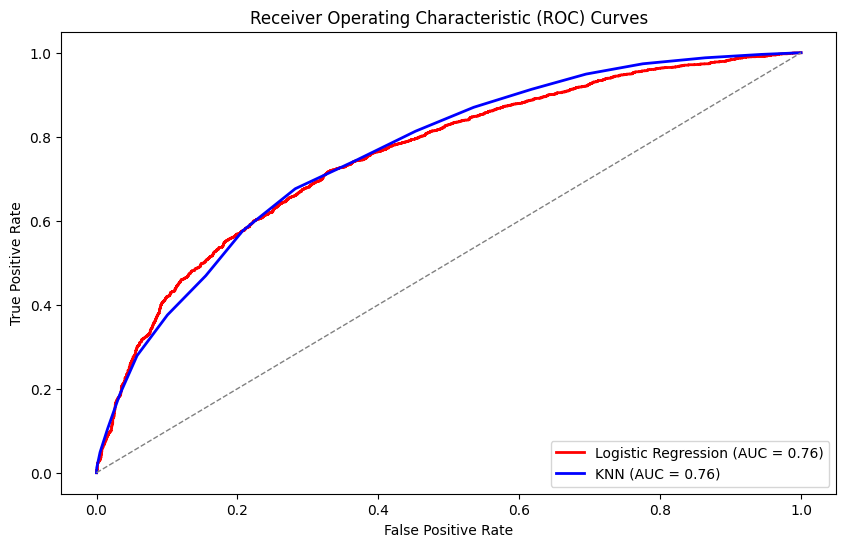

In [54]:
y_pred_proba_logistic = log_model.predict_proba(log_X_test)[:, 1]
fpr_logistic, tpr_logistic, thresholds_logistic = roc_curve(y_test, y_pred_proba_logistic)
roc_auc_logistic = auc(fpr_logistic, tpr_logistic)

y_pred_proba_knn = knn_model.predict_proba(knn_X_test)[:, 1]
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_test, y_pred_proba_knn)
roc_auc_knn = auc(fpr_knn, tpr_knn)

plt.figure(figsize=(10, 6))

plt.plot(fpr_logistic, tpr_logistic, color='red', lw=2, label=f'Logistic Regression (AUC = {roc_auc_logistic:.2f})')

plt.plot(fpr_knn, tpr_knn, color='blue', lw=2, label=f'KNN (AUC = {roc_auc_knn:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)

# Labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()

In [55]:
# LOG
optimal_idx_logistic = np.argmax(tpr_logistic - fpr_logistic)
optimal_threshold_logistic = thresholds_logistic[optimal_idx_logistic]
print(f"Optimal Threshold: {optimal_threshold_logistic:.2f}")

y_pred_optimal = (y_pred_proba_logistic >= optimal_threshold_logistic).astype(int)

accuracy_logistic = accuracy_score(y_test, y_pred_optimal)
print(f"Accuracy For Logistic Regression: {accuracy_score(y_test,y_log_pred):.4f}")
print(f"Accuracy with Optimal Threshold: {accuracy_logistic:.4f}")

# KNN
optimal_idx_knn = np.argmax(tpr_knn - fpr_knn)
optimal_threshold_knn = thresholds_knn[optimal_idx_knn]
print(f"Optimal Threshold: {optimal_threshold_knn:.2f}")

y_pred_optimal = (y_pred_proba_knn >= optimal_threshold_knn).astype(int)

accuracy_knn = accuracy_score(y_test, y_pred_optimal)
print(f"Accuracy For KNN: {accuracy_score(y_test,y_knn_pred):.4f}")
print(f"Accuracy with Optimal Threshold: {accuracy_knn:.4f}")

Optimal Threshold: 0.48
Accuracy For Logistic Regression: 0.6905
Accuracy with Optimal Threshold: 0.6938
Optimal Threshold: 0.53
Accuracy For KNN: 0.6972
Accuracy with Optimal Threshold: 0.6972


# Classification Report

In [56]:
report = classification_report(y_test, y_log_pred, output_dict = True)
report_DataFrame = pd.DataFrame(report).transpose()

filtered_DataFrame = report_DataFrame.loc[['False', 'True'], ['precision', 'recall']]
print(filtered_DataFrame)

       precision    recall
False   0.689643  0.702051
True    0.691390  0.678741


In [57]:
report = classification_report(y_test, y_knn_pred, output_dict = True)
report_DataFrame = pd.DataFrame(report).transpose()

filtered_DataFrame = report_DataFrame.loc[['False', 'True'], ['precision', 'recall']]
print(filtered_DataFrame)

       precision    recall
False   0.692708  0.717884
True    0.702128  0.676180
